# Python

In [33]:
!pip install keras

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#stats models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model

#ML models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

In [4]:
df = pd.read_csv('stock_data.xls')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', errors='coerce')

df = df.dropna()

print(df.dtypes)
print(df.shape)
df.head()

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj_Close           float64
Volume                int64
dtype: object
(4392, 7)


,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000-03-27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000-03-28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000-03-29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000-03-30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000-03-31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


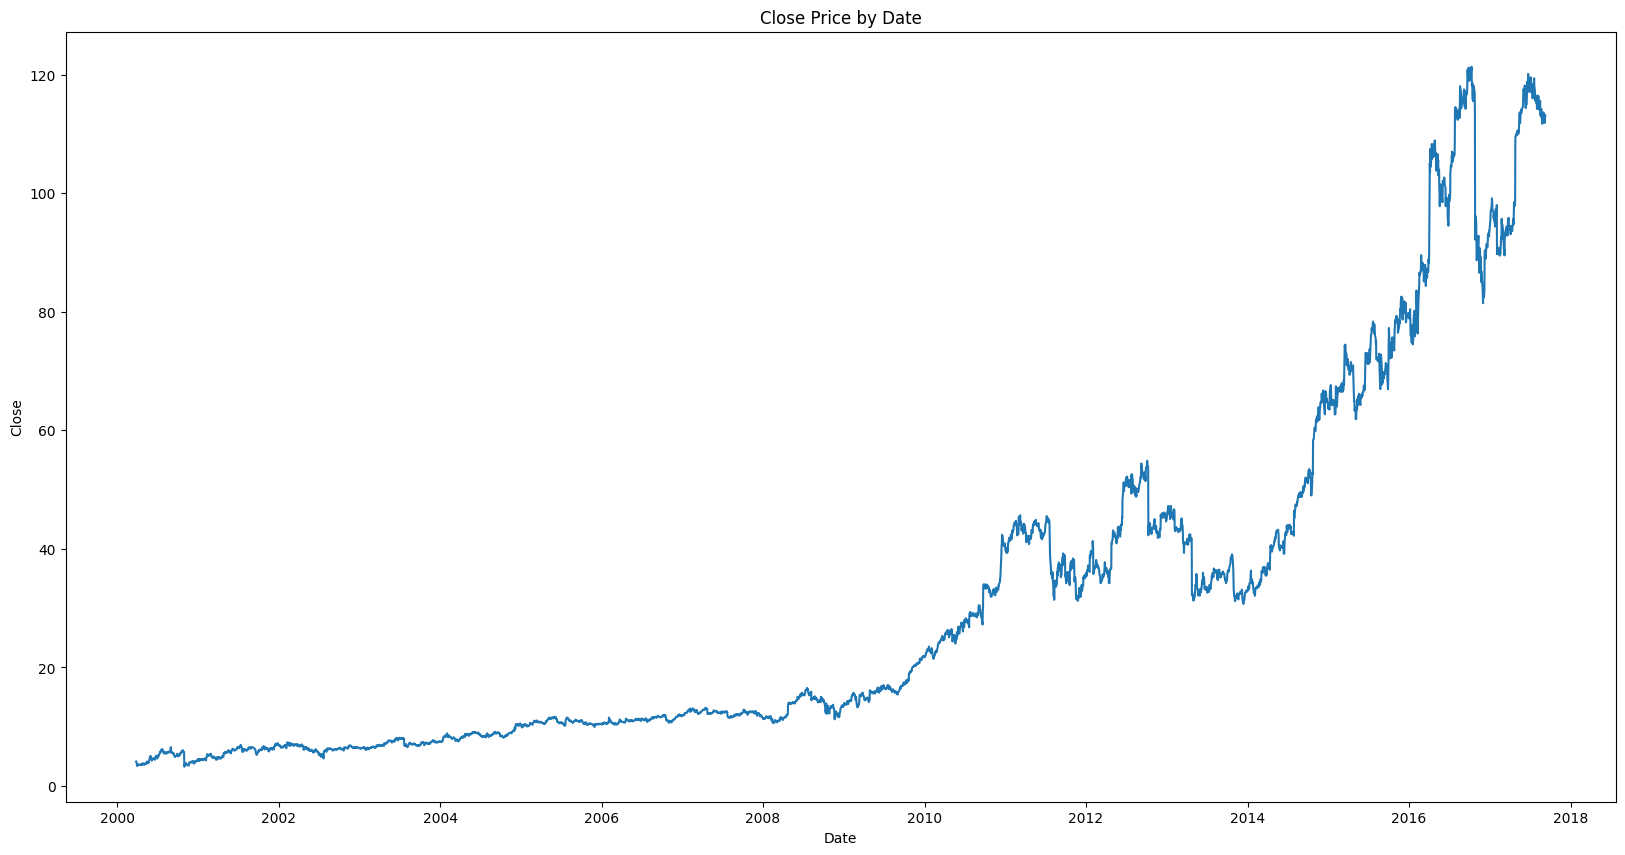

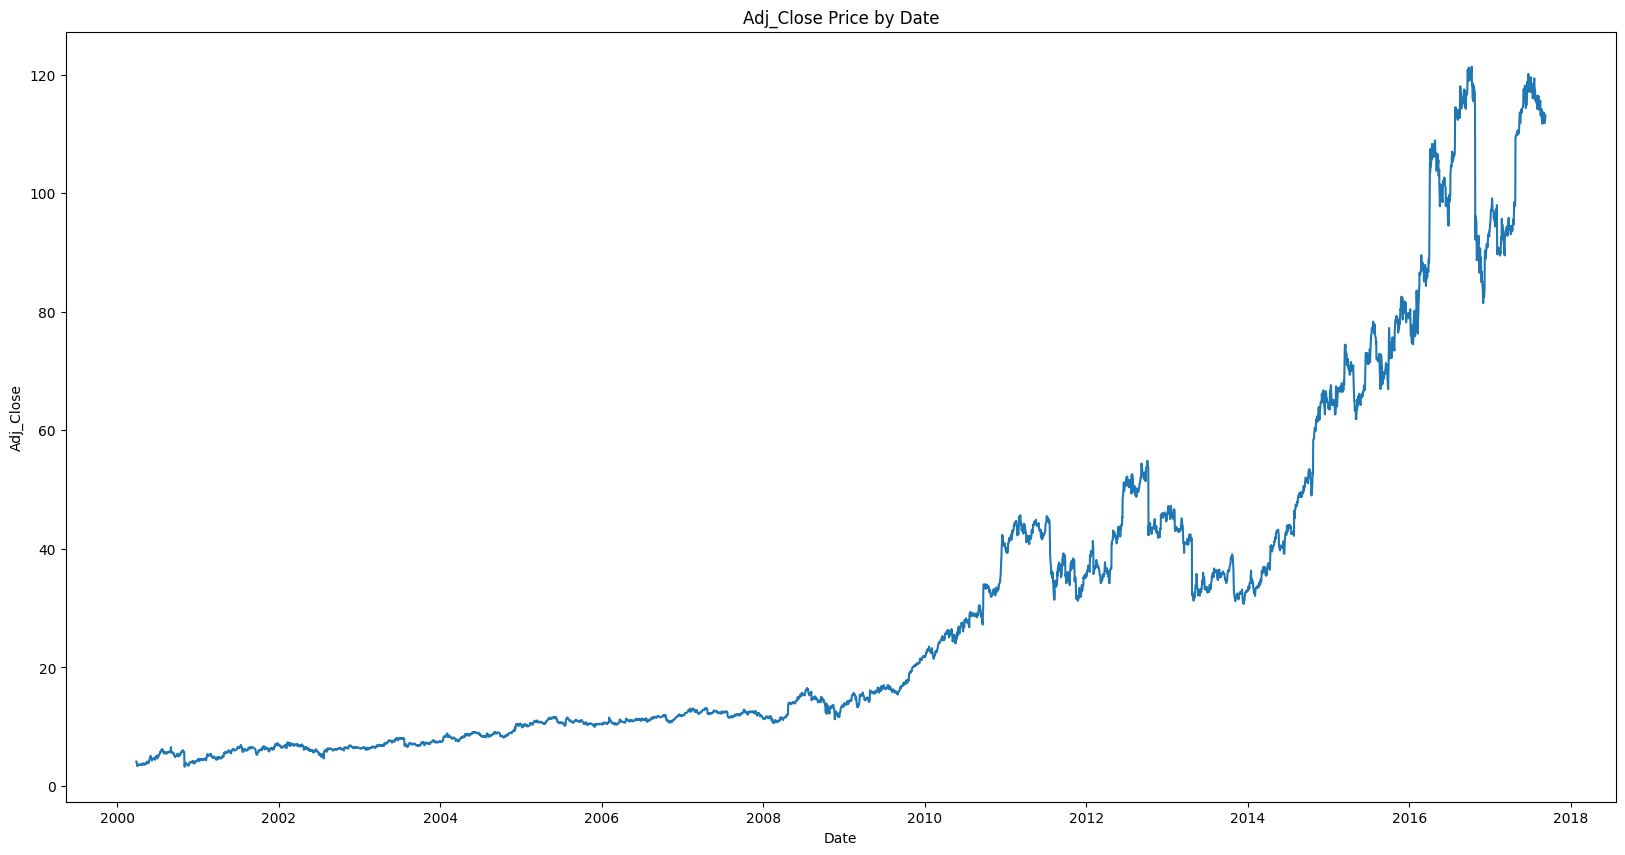

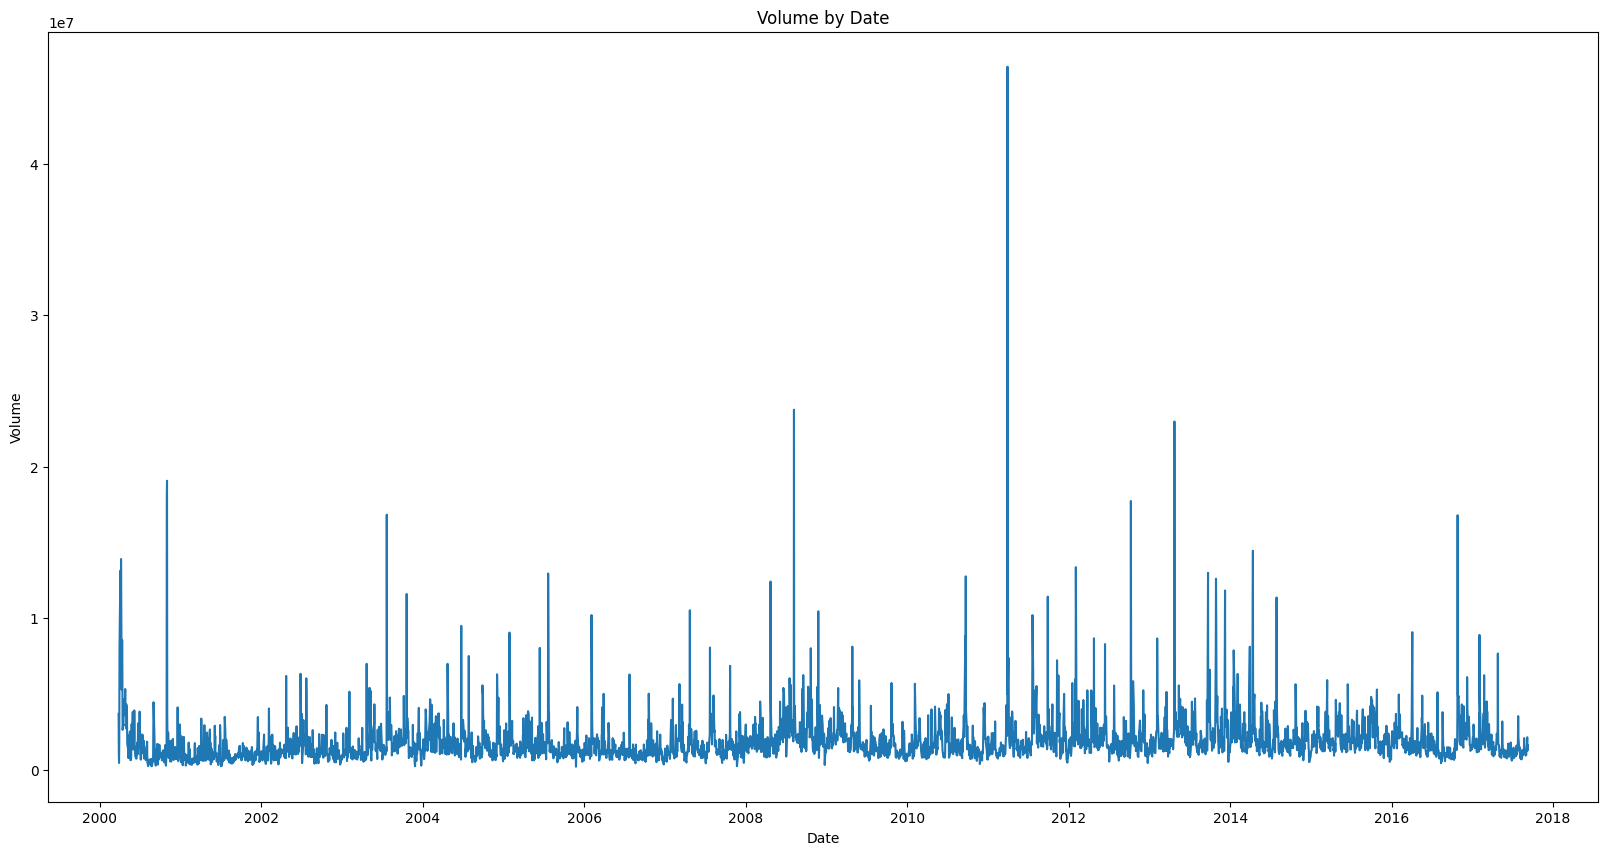

In [5]:
#plot close price
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x='Date', y='Close')
plt.title('Close Price by Date')
plt.show()

#plot adjusted close price
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x='Date', y='Adj_Close')
plt.title('Adj_Close Price by Date')
plt.show()

#plot volume
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x='Date', y='Volume')
plt.title('Volume by Date')
plt.show()

## ARIMA Model for Time Series Regression

In [6]:
# Set 'Date' as the index
df.set_index('Date', inplace=True)
# Sort the index to ensure the time series is in chronological order
df.sort_index(inplace=True)

# We create a new Series containing only the 'Adj_Close' price
ts_data = df['Adj_Close']

# Time series split must be sequential, not random! (e.g., 80% Train, 20% Test)
train_size = int(len(ts_data) * 0.8)

train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

print("--- Data Split Summary ---")
print(f"Total Observations: {len(ts_data)}")
print(f"Training Set Size (80%): {len(train_data)} (from {train_data.index.min().date()} to {train_data.index.max().date()})")
print(f"Testing Set Size (20%): {len(test_data)} (from {test_data.index.min().date()} to {test_data.index.max().date()})")

--- Data Split Summary ---
Total Observations: 4392
Training Set Size (80%): 3513 (from 2000-03-27 to 2014-03-14)
Testing Set Size (20%): 879 (from 2014-03-17 to 2017-09-08)


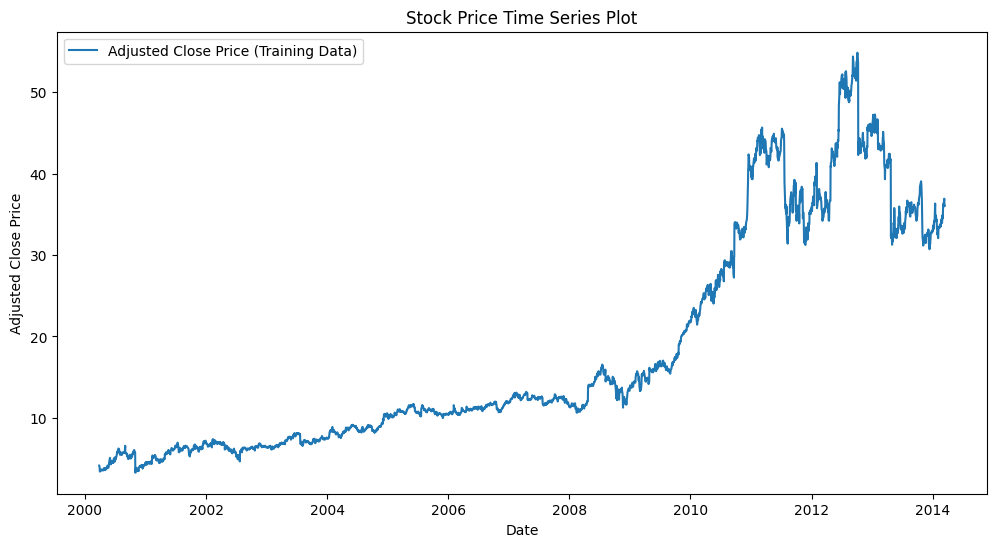

In [7]:
# --- 1. Visual Inspection ---
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Adjusted Close Price (Training Data)')
plt.title('Stock Price Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [8]:
def run_adf_test(timeseries):
    """
    Performs the ADF test and prints the results clearly.
    """
    # The adfuller function returns 5 values:
    # 0: ADF Statistic
    # 1: P-value
    # 2: Number of Lags Used
    # 3: Number of Observations Used
    # 4: Critical Values (1%, 5%, 10%)

    result = adfuller(timeseries, autolag='AIC')

    print('ADF Statistic: %f' % result[0])
    print('P-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Decision based on P-value
    print("\n--- ADF Test Result ---")
    if result[1] <= 0.05:
        print("P-value is <= 0.05. Reject the Null Hypothesis (H0). The series IS LIKELY STATIONARY.")
        return True # Stationary
    else:
        print("P-value is > 0.05. Fail to Reject the Null Hypothesis (H0). The series IS LIKELY NON-STATIONARY.")
        return False # Non-stationary

# Run the test on the original training data
print("--- Augmented Dickey-Fuller (ADF) Test ---")
is_stationary = run_adf_test(train_data)

--- Augmented Dickey-Fuller (ADF) Test ---
ADF Statistic: -0.699859
P-value: 0.846786
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

--- ADF Test Result ---
P-value is > 0.05. Fail to Reject the Null Hypothesis (H0). The series IS LIKELY NON-STATIONARY.


In [9]:
if not is_stationary:
    # Calculate the first difference
    train_data_diff = train_data.diff().dropna()

    print("\n--- Applying First Differencing (d=1) ---")
    print("New Differenced Series Head:")
    print(train_data_diff.head())

    # Run the ADF test on the differenced data
    print("\n--- Re-running ADF Test on Differenced Data ---")
    run_adf_test(train_data_diff)


--- Applying First Differencing (d=1) ---
New Differenced Series Head:
Date
2000-03-28   -0.109375
2000-03-29   -0.015625
2000-03-30   -0.156250
2000-03-31   -0.453125
2000-04-03    0.046875
Name: Adj_Close, dtype: float64

--- Re-running ADF Test on Differenced Data ---
ADF Statistic: -12.406986
P-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567

--- ADF Test Result ---
P-value is <= 0.05. Reject the Null Hypothesis (H0). The series IS LIKELY STATIONARY.


In [10]:
#!pip install pmdarima
# import pmdarima as pm

# print("\n--- Alternative: Auto ARIMA for Optimal p and q Selection ---")

# # Auto ARIMA will automatically find the best (p, d, q) based on AIC
# # We fix d=1 based on our  previous step.
# # seasonal=False because stock prices generally don't have strong fixed annual seasonality.
# auto_model = pm.auto_arima(train_data,
#                            d=1,                # Fixed based on your ADF test result
#                            start_p=0, max_p=5,
#                            start_q=0, max_q=5,
#                            m=1,                # m=1 (non-seasonal)
#                            seasonal=False,
#                            stepwise=True,
#                            suppress_warnings=True,
#                            error_action='ignore')

# print("\nAuto ARIMA Results:")
# print(auto_model.summary())

# # The best order is the one that minimizes the AIC/BIC score
# best_p, best_d, best_q = auto_model.order
# print(f"\nOptimal ARIMA Order (p, d, q) determined by Auto ARIMA: ({best_p}, {best_d}, {best_q})")

--- Analyzing Autocorrelation of the Differenced Series ---


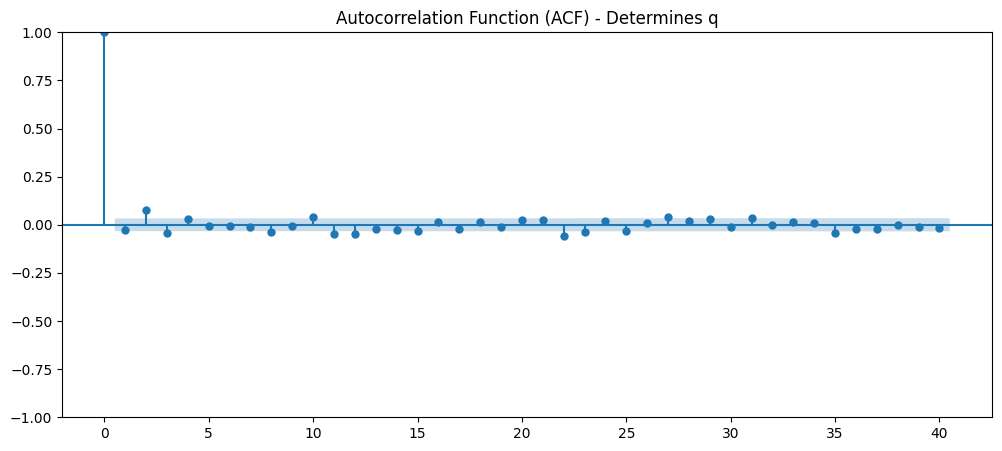

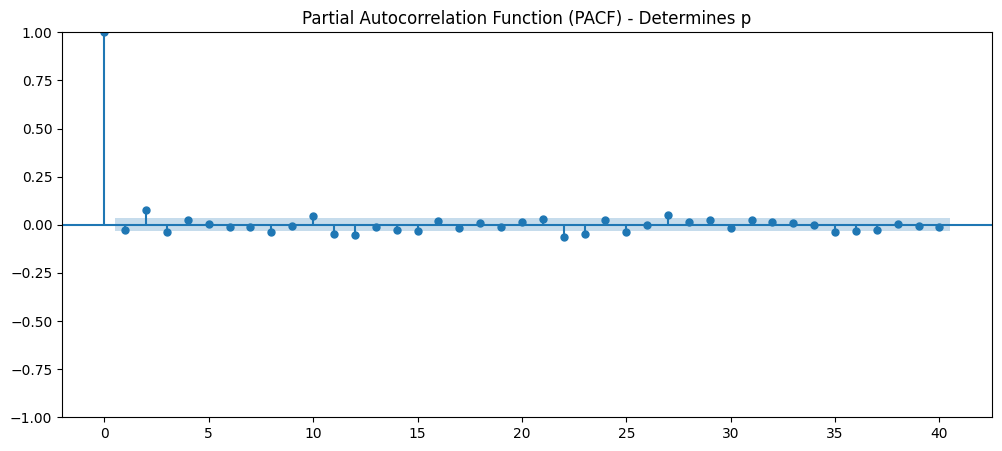

In [11]:
# we will have to perform 1st order diff for the training data
# also, we sill have to set d=1 for the ARIMA() model
train_data_diff = train_data.diff().dropna()

print("--- Analyzing Autocorrelation of the Differenced Series ---")
# the ACF plot helps determine the 'q' (Moving Average) order.
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train_data_diff, ax=ax, lags=40, title='Autocorrelation Function (ACF) - Determines q')
plt.show()

# the PACF plot helps determine the 'p' (Autoregressive) order.
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train_data_diff, ax=ax, lags=40, title='Partial Autocorrelation Function (PACF) - Determines p')
plt.show()

Interpretation Guidelines for p and q

The blue shaded area on the plots represents the 95% confidence interval. Any bar extending outside this area is statistically significant.

- p (AR Order) comes from the PACF Plot. it is the lag where the PACF plot cuts off (i.e., the last significant spike outside the blue zone).
- q (MA Order) comes from the ACF Plot. it is the lag where the ACF plot cuts off (i.e., the last significant spike outside the blue zone).

In [12]:
#interpreting the ACF and PACF plots, we should set:
p = 2
d = 1
q = 2
order = (p, d, q)

print(f"--- Fitting ARIMA{order} Model on Training Data ---")

# fit the ARIMA Model
try:
    # Note: we use the non-differenced training data (train_data),
    # as the 'd' parameter handles differencing internally.
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()

    print(model_fit.summary())

except Exception as e:
    print(f"Error fitting model: {e}")
    print("If you encounter an error like 'non-invertible' or 'non-stationary', try slightly different (p, q) values.")
    print("-" * 50)
    exit()

--- Fitting ARIMA(2, 1, 2) Model on Training Data ---


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj_Close   No. Observations:                 3513
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2338.750
Date:                Mon, 08 Dec 2025   AIC                           4687.500
Time:                        22:14:58   BIC                           4718.320
Sample:                             0   HQIC                          4698.498
                               - 3513                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2187      0.038    -32.467      0.000      -1.292      -1.145
ar.L2         -0.8193      0.033    -24.945      0.000      -0.884      -0.755
ma.L1          1.2105      0.035     34.831      0.0

Key Finding: Since all P-values are 0.000 (well below the 0.05 threshold), all of the chosen parameters (p=2 and q=2) are statistically significant and essential to the model's structure.

The diagnostics check if the model's residuals (the errors or the difference between the actual and predicted values) behave like white noise, which is an assumption for a good model.

- Diagnostic Test	Value	P-value	Interpretation & Warning
- Ljung-Box (L1) (Q)	0.66	0.42	Good. Since P(Q)>0.05, there is no significant autocorrelation left in the residuals. This is the most important positive result for an ARIMA model!
- Jarque-Bera (JB)	3.1×106	0.00	Bad (but common). P(JB)<0.05 means the residuals are NOT normally distributed. This is typical for stock returns, which exhibit "fat tails" (extreme events happen more often than a normal distribution suggests).
- Heteroskedasticity (H)	23.25	0.00	Bad. P(H)<0.05 means the residuals suffer from Heteroskedasticity (the variance of the errors is not constant over time). For stock data, this is often called volatility clustering (big price movements are followed by big price movements).

Root Mean Square Error (RMSE) on Test Data: 50.8840


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


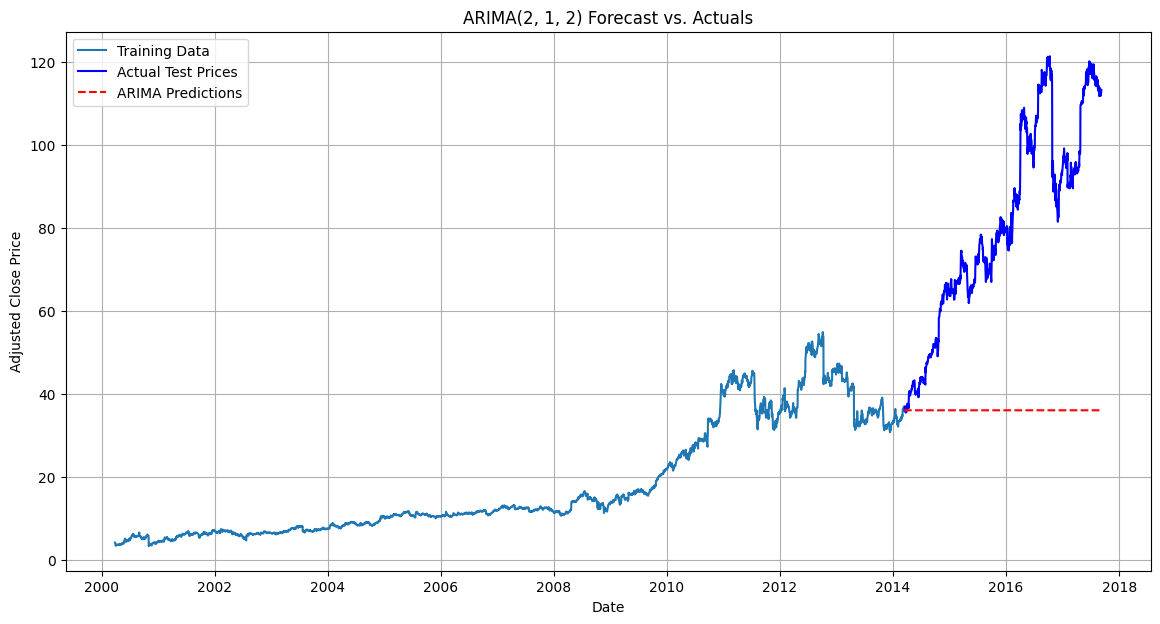

In [13]:
# generate predictions on the test set
start = len(train_data)
end = len(train_data) + len(test_data) - 1

predictions = model_fit.predict(start=start, end=end, dynamic=False)
predictions.index = test_data.index

# Create a DataFrame for easy comparison
forecast_df = pd.DataFrame({
    'Actual': test_data,
    'Predicted': predictions
})

# ealuate model performance
# we use Root Mean Square Error (RMSE) to measure the average magnitude of the errors
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"Root Mean Square Error (RMSE) on Test Data: {rmse:.4f}")

# visualize the Forecast vs. Actuals
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Test Prices', color='blue')
plt.plot(predictions, label='ARIMA Predictions', color='red', linestyle='--')
plt.title(f'ARIMA{order} Forecast vs. Actuals')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

It seems that the ARIMA model is good at fitting past data, but bad at predicting future data, as it outputs all constant values...

We will try other approaches

## GARCH Model

In [15]:
#We can combine GARCH with ARIMA. Garch models the variance of the data

# We use the residuals from the differenced series (d=1) for GARCH fitting
residuals = model_fit.resid.dropna()
print(f"Residuals extracted for GARCH modeling (Length: {len(residuals)}).")

# prepare the Differenced (1) Series for GARCH
returns = train_data.diff().dropna()

Residuals extracted for GARCH modeling (Length: 3513).


In [31]:
# 4. Fit the GARCH(1, 1) Model
# GARCH(1, 1) is typically sufficient and the most common choice.
# p=1 for ARCH, q=1 for GARCH.
print("\n--- 5. Fitting GARCH(1, 1) to ARIMA Residuals ---")

# We fit GARCH on the returns data, but the 'mean' part is already handled by ARIMA
# We use the 'resid' of the ARIMA model as the input for GARCH
garch_model = arch_model(returns,
                         mean='ARX',            # Use ARX for mean modeling
                         lags=p,          # Set AR order from ARIMA
                         vol='Garch',           # Use GARCH for volatility
                         p=1, q=1)              # GARCH(1, 1) orders

# The ARIMA (2, 1, 2) model is complex to perfectly integrate in a single ARCH model object.
# A simpler and more common approach is to use the STANDARDIZED RESIDUALS.
# Let's use the standard method: Fit GARCH on the ARIMA residuals directly.

# Square the residuals to get a proxy for the variance
squared_residuals = residuals ** 2

# Fit GARCH(1, 1) to the residuals themselves
garch_model = arch_model(residuals, mean='Constant', vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

print(garch_fit.summary())

# Forecast the next 30 steps (e.g., 30 days) of volatility
forecast_horizon = len(test_data)
garch_forecast = garch_fit.forecast(horizon=forecast_horizon)

# Extract the predicted conditional volatility (standard deviation)
# The forecast variance is the 'h.1' column (variance at time t+1)
# We take the square root to get the standard deviation (volatility)
volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

forecast_df['Predicted_Volatility'] = volatility_forecast
forecast_df['Predicted_ci_upper'] = forecast_df['Predicted'] + 1.96 * forecast_df['Predicted_Volatility']
forecast_df['Predicted_ci_lower'] = forecast_df['Predicted'] - 1.96 * forecast_df['Predicted_Volatility']
forecast_df


--- 5. Fitting GARCH(1, 1) to ARIMA Residuals ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -523.983
Distribution:                  Normal   AIC:                           1055.97
Method:            Maximum Likelihood   BIC:                           1080.62
                                        No. Observations:                 3513
Date:                Mon, Dec 08 2025   Df Residuals:                     3512
Time:                        22:35:17   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu  

,Actual,Predicted,Predicted_Volatility,Predicted_GARCH_upper,Predicted_GARCH_lower,Predicted_ci_upper,Predicted_ci_lower
Date,,,,,,,
2014-03-17,36.185001,35.972114,0.530755,37.012394,34.931834,37.012394,34.931834
2014-03-18,36.465000,36.012995,0.530899,37.053558,34.972433,37.053558,34.972433
2014-03-19,36.965000,36.043371,0.531043,37.084215,35.002526,37.084215,35.002526
2014-03-20,36.514999,35.972858,0.531187,37.013984,34.931731,37.013984,34.931731
2014-03-21,36.064999,36.033906,0.531331,37.075314,34.992497,37.075314,34.992497
...,...,...,...,...,...,...,...
2017-09-01,113.309998,36.011969,0.642555,37.271377,34.752561,37.271377,34.752561
2017-09-05,111.870003,36.011969,0.642670,37.271601,34.752336,37.271601,34.752336
2017-09-06,112.230003,36.011969,0.642784,37.271826,34.752112,37.271826,34.752112


Analysis of the Corrected GARCH(1, 1) Results
1. Mean Model (Constant Mean)

    mu (Mean): The coefficient for the mean of the residuals = 0.0057.

    P-value: 0.066. This is slightly above the standard 0.05 significance level, meaning the mean of the residuals is statistically indistinguishable from zero.

    Interpretation: This is a good result. It confirms that the prior ARIMA(2, 1, 2) model successfully captured the entire mean structure of the stock price changes, leaving behind residuals that are essentially centered at zero.

2. Volatility Model (GARCH) - The Key Section

This is where we look at the coefficients that determine how volatility evolves.

- coef (Weight) Insignificant. This is the long-run average variance (baseline volatility). It is close to zero, which is common.
- alpha[1] = 0.0253  Marginally Significant. This is the ARCH term (how much yesterday's shock affects today's volatility). A low value suggests recent shocks have little direct impact.
- beta[1] = 0.9746 Highly Significant. This is the GARCH term (how much yesterday's volatility affects today's volatility).

## Machine Learning - Regression

We'll train a RNN and an XGBoost model to try and fit the data

In [35]:
# Define the lookback window (how many previous days to use to predict the next day)
LOOKBACK_WINDOW = 60

# --- Data Preparation (Scaling and Sequencing) ---
# Reshape data to be used by the scaler (needs a 2D array)
scaler = MinMaxScaler(feature_range=(0, 1))
ts_data_scaled = scaler.fit_transform(ts_data.values.reshape(-1, 1))

# Split the scaled data (the split point is the same as before)
train_scaled = ts_data_scaled[:train_size]
test_scaled = ts_data_scaled[train_size - LOOKBACK_WINDOW:] # Include LOOKBACK_WINDOW prior steps for test set sequencing

print(f"Train Scaled Length: {len(train_scaled)}")
print(f"Test Scaled Length (including lookback): {len(test_scaled)}")

Train Scaled Length: 3513
Test Scaled Length (including lookback): 939


In [36]:
def create_sequences(data, lookback):
    """
    Function to create the X (features) and Y (target) sequences.
    X: [t-lookback, t-lookback+1, ..., t-1]
    Y: [t] (the price at time t)
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Create sequences for training
X_train, y_train = create_sequences(train_scaled, LOOKBACK_WINDOW)

# Create sequences for testing
X_test, y_test = create_sequences(test_scaled, LOOKBACK_WINDOW)


# Reshape X for LSTM input: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("\n--- Sequence Shape Summary ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")


--- 2. Sequence Shape Summary ---
X_train shape: (3453, 60, 1)
y_train shape: (3453,)
X_test shape: (879, 60, 1)


In [37]:
# --- 2. Model Construction ---

print("\n--- Building LSTM Model ---")
model = Sequential()
# Layer 1: LSTM with 50 units, returns sequences for the next LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(LOOKBACK_WINDOW, 1)))
model.add(Dropout(0.2))

# Layer 2: Final LSTM layer (does not return sequences)
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output Layer: Dense layer for the single price prediction
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


--- Building LSTM Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# --- Training and Forecasting ---

print("--- Training Model (may take a few minutes) ---")
# Train the model
# Using a small batch size and moderate epochs for quick results
history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1, validation_split=0.1)


print("--- Generating Predictions ---")
# Make predictions on the test set
predicted_price_scaled = model.predict(X_test)

# Inverse transform the predictions to get the original price scale
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Extract the actual prices for comparison
actual_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame for easy comparison
lstm_forecast_df = pd.DataFrame({
    'Actual': actual_price.flatten(),
    'Predicted': predicted_price.flatten()
}, index=ts_data.index[train_size : train_size + len(predicted_price)]) # Align index correctly

print("\n--- LSTM Forecast vs. Actuals Summary ---")
print(lstm_forecast_df.tail())


--- LSTM Forecast vs. Actuals Summary ---
                Actual   Predicted
Date                              
2017-09-01  113.309998  101.940186
2017-09-05  111.870003  102.117577
2017-09-06  112.230003  102.043770
2017-09-07  112.339996  101.944801
2017-09-08  113.190002  101.864380


In [41]:
# --- Data Preparation for Metrics ---
# Extract the actual and predicted values from the aligned DataFrame
actuals = lstm_forecast_df['Actual'].values
predictions = lstm_forecast_df['Predicted'].values

# --- 1. Calculate Metrics ---

# A. Mean Squared Error (MSE)
# Measures the average squared difference between the estimated values and the actual value.
# Penalizes larger errors more severely.
mse = mean_squared_error(actuals, predictions)

# B. Root Mean Squared Error (RMSE)
# The square root of the MSE. It's in the same units as the stock price, making it highly interpretable.
rmse = np.sqrt(mse)

# C. Mean Absolute Error (MAE)
# Measures the average magnitude of the errors. Less sensitive to outliers than MSE/RMSE.
mae = mean_absolute_error(actuals, predictions)

# D. R-squared (R2 Score)
# Represents the proportion of the variance in the dependent variable (stock price) that is
# predictable from the independent variables (past prices). Closer to 1.0 is better.
r2 = r2_score(actuals, predictions)


# --- 2. Print Results ---

print("=" * 40)
print("      LSTM Model Performance Metrics")
print("=" * 40)
print(f"Mean Squared Error (MSE):       {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"R-squared (R2 Score):           {r2:.4f}")
print("=" * 40)

      LSTM Model Performance Metrics
Mean Squared Error (MSE):       53.0480
Root Mean Squared Error (RMSE): 7.2834
Mean Absolute Error (MAE):      6.2328
R-squared (R2 Score):           0.9083


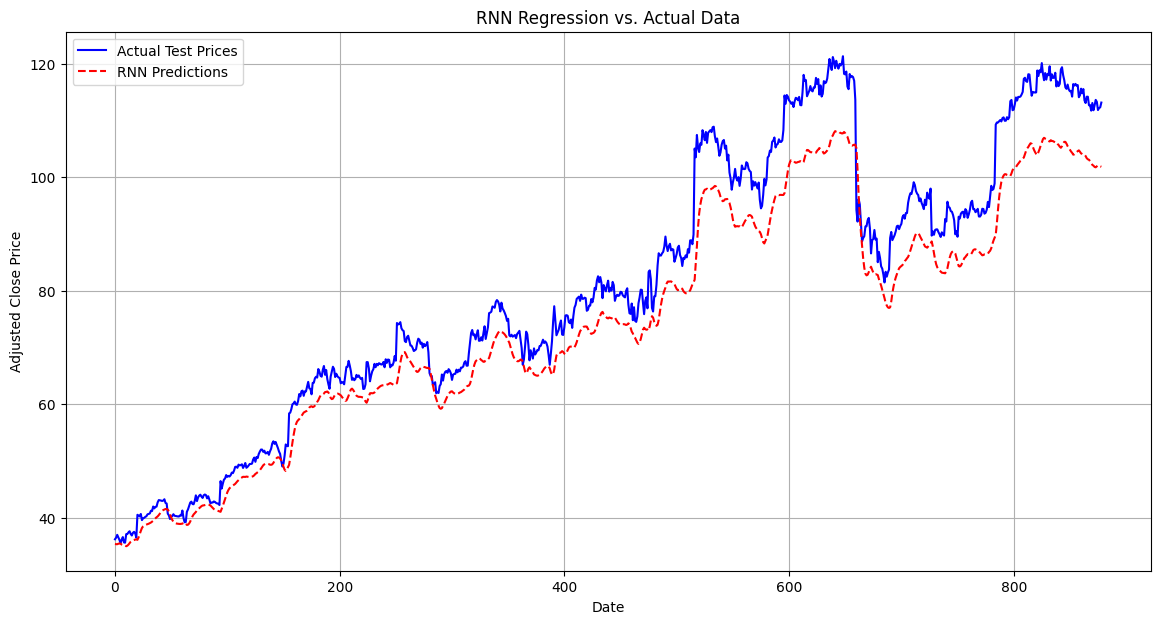

In [43]:
# visualize the Forecast vs. Actuals
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual Test Prices', color='blue')
plt.plot(predictions, label='RNN Predictions', color='red', linestyle='--')
plt.title('RNN Regression vs. Actual Data')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost Regressor (tree)